In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re 


In [45]:
df = pkl.load(open('project8.pkl', 'rb'))
df.head()

,Unnamed: 0,post_id,self_text,user_is_verified,controversiality,ups,downs,subreddit,score,user_awardee_karma,user_awarder_karma,user_total_karma,user_comment_karma,user_link_karma,post_score,post_upvote_ratio,post_thumbs_up,post_total_awards_ratio,post_created_time
0,1979,9grgvl,"Yes, modeling anything with less resolution i...",True True True True True True True,0.142857,2.857143,0,climate_science,2.857143,8.571429,0.000000,11034.571429,10438.285714,587.714286,33,0.97,33,0,2018-09-18 03:59:40
1,503,1anritd,"Thing is, there's no official paper that desc...",True True True True True True True,0.000000,9.000000,0,climateskeptics,9.000000,748.142857,9.571429,91926.000000,42031.571429,49136.714286,67,0.94,67,0,2024-02-10 21:56:09
2,1387,16xyvqf,I read that article a month ago. Not sure wh...,True,0.000000,2.000000,0,climateskeptics,2.000000,315.000000,0.000000,37103.000000,36305.000000,483.000000,7,0.73,7,0,2023-10-02 14:58:12
3,918,18ii60q,&gt; Dr. Paul Pettré provides a damning critq...,True,0.000000,3.000000,0,climateskeptics,3.000000,1683.000000,20.000000,164653.000000,63989.000000,98961.000000,12,0.93,12,0,2023-12-14 20:42:33
4,1375,16zuc0a,This was a really good interview. She really ...,False,0.000000,3.000000,0,climateskeptics,3.000000,1703.000000,114.000000,1817.000000,0.000000,0.000000,27,0.97,27,0,2023-10-04 18:12:08


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2027 entries, 0 to 2026
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               2027 non-null   int64  
 1   post_id                  2027 non-null   object 
 2   self_text                2027 non-null   object 
 3   user_is_verified         2027 non-null   object 
 4   controversiality         2027 non-null   float64
 5   ups                      2027 non-null   float64
 6   downs                    2027 non-null   int64  
 7   subreddit                2027 non-null   object 
 8   score                    2027 non-null   float64
 9   user_awardee_karma       2022 non-null   float64
 10  user_awarder_karma       2022 non-null   float64
 11  user_total_karma         2022 non-null   float64
 12  user_comment_karma       2022 non-null   float64
 13  user_link_karma          2022 non-null   float64
 14  post_score              

### Task 1

In [64]:
df["preprocessed_text"] = df["self_text"].apply(lambda x: x.lower())

In [81]:
stop_words = set(stopwords.words('english'))
df["tokenized_text"] = df["preprocessed_text"].apply(lambda x: word_tokenize(x))
df["tokenized_text"] = df["tokenized_text"].apply(lambda x: [word for word in x if word not in stop_words])
df["tokenized_text"] = df["tokenized_text"].apply(lambda x: [word for word in x if word.isalpha()])
df["tokenized_text"] = df["tokenized_text"].apply(lambda x: [word for word in x if len(word) > 1]) # remove single character words, this can help with removing punctuation. 

In [82]:
#group by subreddit
grouped = df.groupby('subreddit')
df_cli_sci = grouped.get_group('climate_science')
df_cli_skp = grouped.get_group('climateskeptics')

print(df_cli_sci.shape)
print(df_cli_skp.shape)

(442, 21)
(1585, 21)


In [83]:
cli_sci_words = [word for words in df_cli_sci["tokenized_text"].values for word in words]
cli_skp_words = [word for words in df_cli_skp["tokenized_text"].values for word in words]

In [84]:
print(len(cli_sci_words))
print(len(cli_skp_words))

120669
473357


In [90]:
common_words = set()
with open ("common_words.txt", "r") as f:
    for line in f:
        common_words.add(line.strip())
        
print(common_words)

cli_sci_words = [word for word in cli_sci_words if word not in common_words]
cli_skp_words = [word for word in cli_skp_words if word not in common_words]

print(len(cli_sci_words))
print(len(cli_skp_words))


{'energy', 'https', 'temperatures', 'thing', 'think', 'atmosphere', 'scientists', 'without', 'well', 'global', 'climate', 'one', 'know', 'even', 'increase', 'use', 'need', 'temperature', 'make', 'people', 'model', 'things', 'models', 'many', 'year', 'scientist', 'years', 'warming', 'data', 'still', 'point', 'see', 'time', 'earth', 'http', 'take', 'humans', 'every', 'human', 'really', 'way', 'co2', 'much', 'going', "n't", 'water', 'gt', 'say', 'maybe', 'science', 'change'}
102088
400272


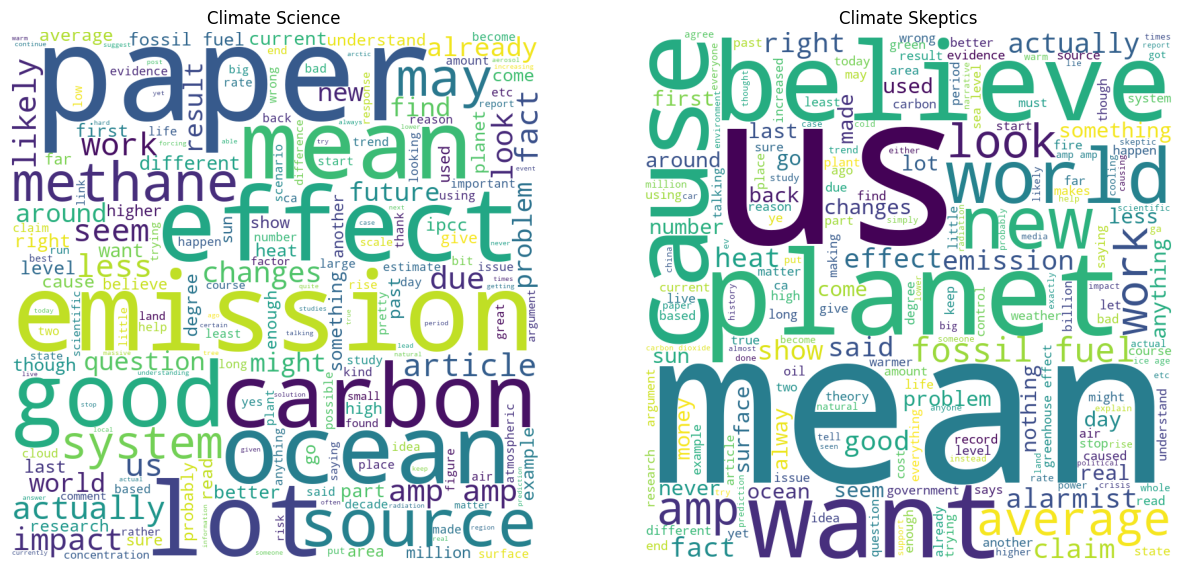

In [92]:
#word cloud for climate science and climate skeptics in subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 15))

wordcloud_cli_sci = WordCloud(width=800, height=800, background_color='white').generate(' '.join(cli_sci_words))
ax[0].imshow(wordcloud_cli_sci)
ax[0].axis('off')
ax[0].set_title('Climate Science')

wordcloud_cli_skp = WordCloud(width=800, height=800, background_color='white').generate(' '.join(cli_skp_words))
ax[1].imshow(wordcloud_cli_skp)
ax[1].axis('off')
ax[1].set_title('Climate Skeptics')

plt.show()

### Task 2

In [54]:
#TF-IDF
combined_text = [df_cli_sci["preprocessed_text"].values, df_cli_skp["preprocessed_text"].values]
combined_text = np.concatenate(combined_text)

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(combined_text)
print(tfidf_matrix.shape)



(2027, 36578)
